### Data Science Programming 2

# Final Project 

## Task 2:
1. Select any dataset that will suit for clustering
2. Observe your data
3. Apply some data preparation
4. Apply clustering model
5. Visualise your obtained clusters

## Importing libraries

In [1]:
# Data tools
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Colormap
import seaborn as sns

# preprocessing
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import scale

# Model build and evaluation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

# other
import warnings
warnings.filterwarnings('ignore')

## Select any dataset that will suit for clustering

To demonstrate skills in solving data clustering problems, a typical customer dataset was chosen.

This is the data of the customers of the supermarket chain, where the customer's gender, age, annual income and estimated expenses are indicated.

By segmenting users into clusters, the company wants to offer unique services to different customers. Also, having determined the target audience of the product, the marketing department will be able to plan PR strategies.

**Link to dataset:** [link](https://www.kaggle.com/datasets/dev0914sharma/customer-clustering)

### Importing dataset from kaggle

In [2]:
data = pd.read_csv('dataset.csv')
data.head()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1


In [3]:
print(data.shape)

(2000, 8)


## Observe your data

### Short description of features

- ID: Unique anonymized id of customer
- Sex:
  - 0 - Male
  - 1 - Female
- Marital status
  - 0 - Single
  - 1 - Non-single (divorced / separated / married / widowed)
- Age: age of customer
- Education:
  - 0 - Unknown
  - 1 - High school
  - 2 - University
  - 3 - Graduate
- Income: Self-reported annual income of customer per year (in US dollars)
- Occupation:
  - 0 - Unemployed / unskilled
  - 1 - Skilled employee / official
  - 2 - Management / self-employed / highly qualified employee / officer
- Settlement
  - 0 - Small city
  - 1 - Medium sity
  - 2 - Large city

ID is a variable with only distinct values which have no any useful information so we should drop it.

In [4]:
data.drop(['ID'], axis=1, inplace=True)
print(data.shape)

(2000, 7)


Also there is a unknown values(0) for Education field. It can be counted as NaN values.

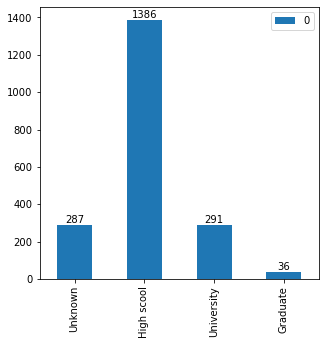

In [5]:
plt.rcParams['figure.figsize'] = (5, 5)

education_distr = np.unique(data['Education'], return_counts=True)

pd.DataFrame(education_distr[1], index=['Unknown', 'High scool', 'University', 'Graduate']).plot.bar()

for i in range(4):
    plt.text(i, education_distr[1][i], education_distr[1][i], ha='center', va='bottom')

The number of rows with missing values(0) is 287. A good idea to drop them to not hurn clustering quality.

In [6]:
data['Education'] = data['Education'].apply(lambda x: np.nan if x == 0 else x)
data.dropna(inplace=True)
print(data.shape)

(1713, 7)


## Descriptive analysis

### Identifying numerical and categorical variables

In [7]:
data.dtypes

Sex                  int64
Marital status       int64
Age                  int64
Education          float64
Income               int64
Occupation           int64
Settlement size      int64
dtype: object

According to dataset description there are 5 categorical variables and 2 continuous variables

Text(0.5, 1.0, 'Income')

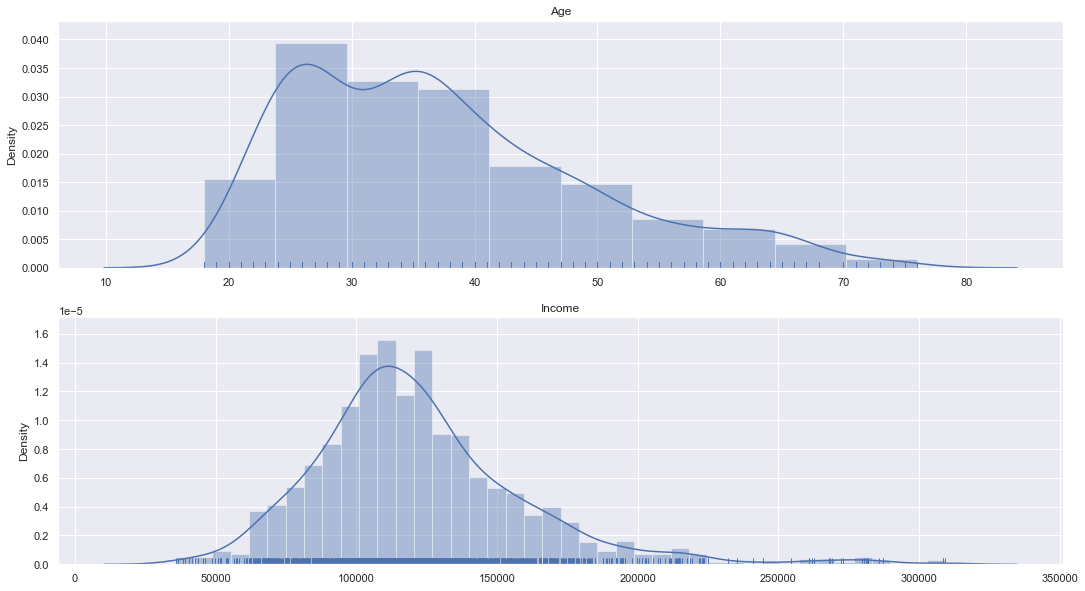

In [8]:
sns.set()
fig, axes = plt.subplots(2, 1, figsize=(18, 10))

sns.distplot(ax=axes[0], x=data['Age'], rug=True, bins=10).set_title('Age')
sns.distplot(ax=axes[1], x=data['Income'], rug=True).set_title('Income')

From plots above we can see that Age has a right-skewed distribution an Income has normal distribution with outliers in the right part.

### Quantifying missing data

In [9]:
data.isna().sum()

Sex                0
Marital status     0
Age                0
Education          0
Income             0
Occupation         0
Settlement size    0
dtype: int64

There is no NaN values in dataset.

### Determining cardinality in categorical variables

Text(0.5, 1.0, 'Cardinality')

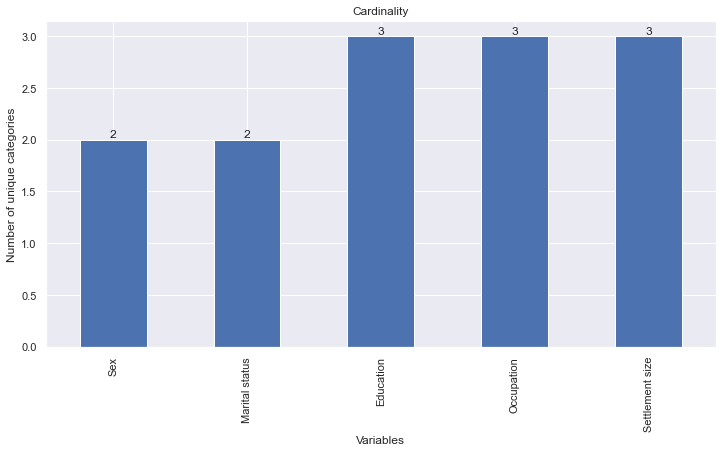

In [10]:
num_unique = data.drop(['Age', 'Income'], axis=1).nunique()
num_unique.plot.bar(figsize=(12,6))

for i in range(5):
    plt.text(i, num_unique[i], num_unique[i], ha='center', va='bottom')

plt.ylabel('Number of unique categories')
plt.xlabel('Variables')
plt.title('Cardinality')

There are two features with binary classification and three with three unique values.

### Pinpointing rare categories in categorical variables

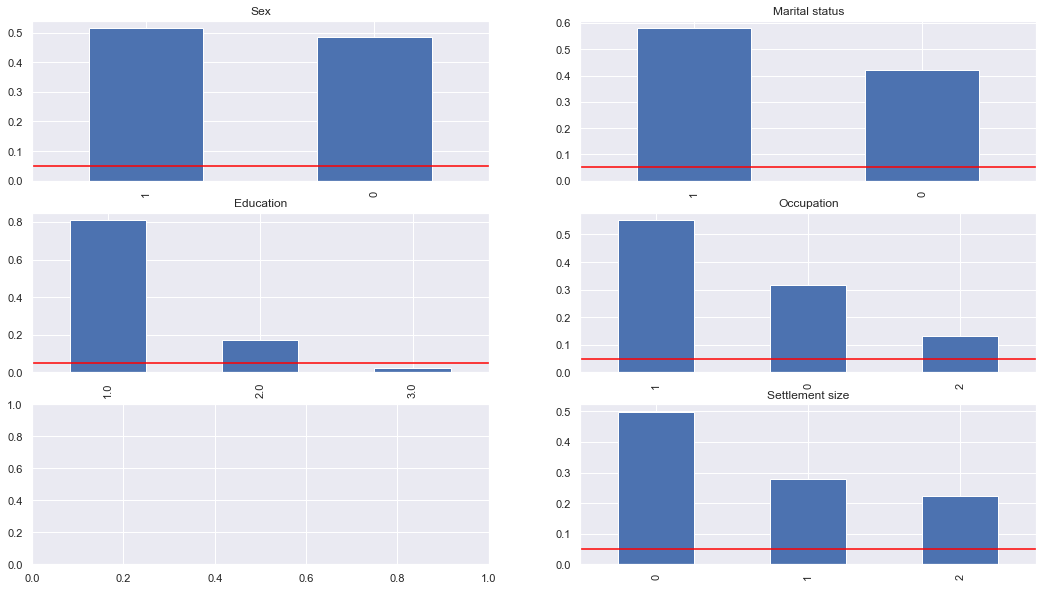

In [11]:
sns.set()
fig, axes = plt.subplots(3, 2, figsize=(18, 10))


label_freq = data['Sex'].value_counts() / len(data)
label_freq.sort_values(ascending=False).plot.bar(ax=axes[0,0]).set_title('Sex')
axes[0,0].axhline(y=0.05, color='red')

label_freq = data['Marital status'].value_counts() / len(data)
label_freq.sort_values(ascending=False).plot.bar(ax=axes[0,1]).set_title('Marital status')
axes[0,1].axhline(y=0.05, color='red')

label_freq = data['Education'].value_counts() / len(data)
label_freq.sort_values(ascending=False).plot.bar(ax=axes[1,0]).set_title('Education')
axes[1,0].axhline(y=0.05, color='red')

label_freq = data['Occupation'].value_counts() / len(data)
label_freq.sort_values(ascending=False).iloc[:15].plot.bar(ax=axes[1,1]).set_title('Occupation')
axes[1,1].axhline(y=0.05, color='red')

label_freq = data['Settlement size'].value_counts() / len(data)
label_freq.sort_values(ascending=False).iloc[:15].plot.bar(ax=axes[2,1]).set_title('Settlement size')
axes[2,1].axhline(y=0.05, color='red')

From graphic above we can see that there a rare category("Graduate") for Education variable.

Also we can see a small amount of customers from large cities.

### Identifying a linear relationship

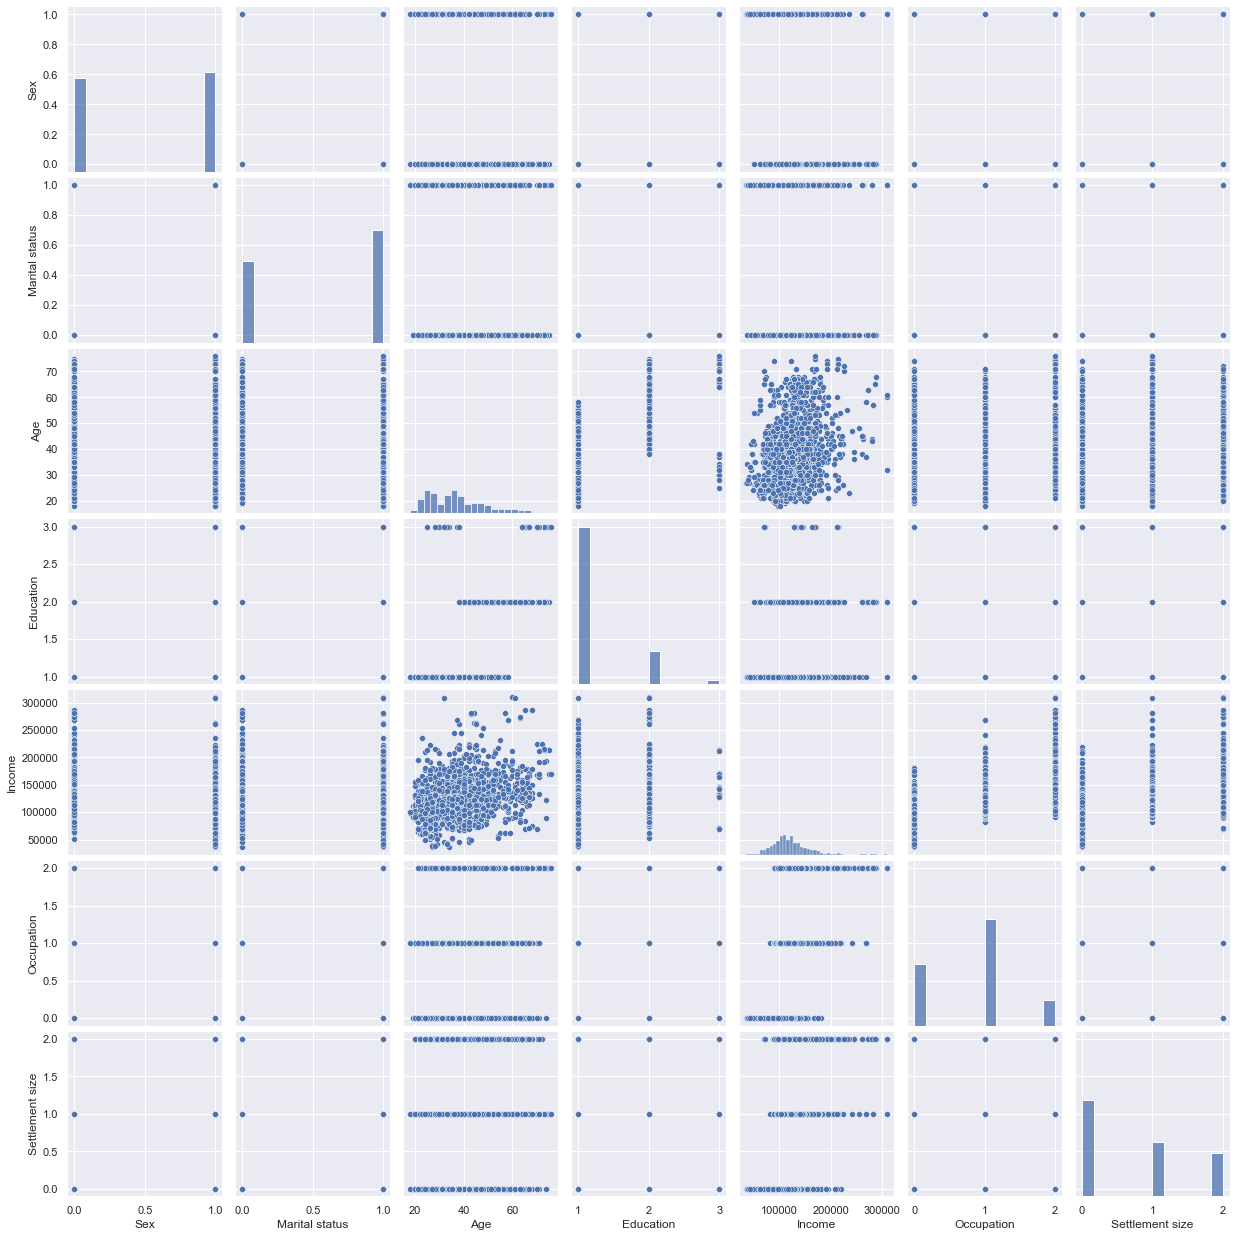

In [12]:
plt.rcParams['figure.figsize'] = (15, 15)
sns.pairplot(data)

<AxesSubplot:>

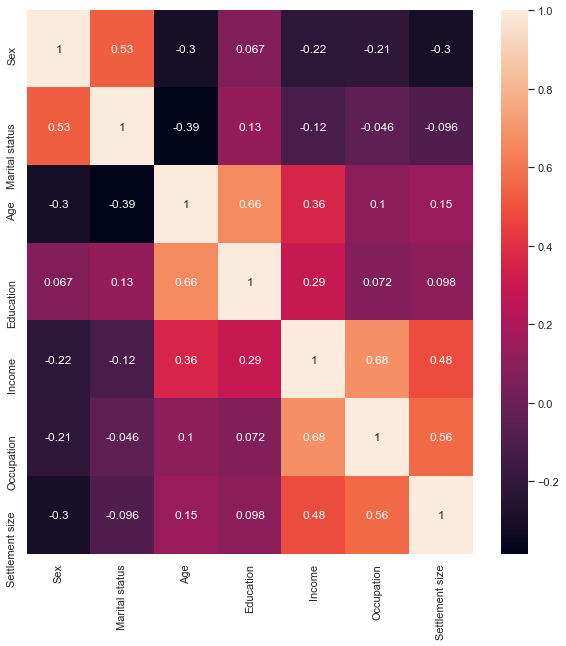

In [13]:
plt.rcParams['figure.figsize'] = (10, 10)
sns.heatmap(data.corr(), annot=True)

From plots above we can define:
- Median correlation between Sex and Marital status
- Median correltaion between Settlement size and Income and Occupation
- Median correltion between Income and Age and weak correltaion between Income and Education

### Highlighting outliers

Text(0.5, 1.0, 'Income')

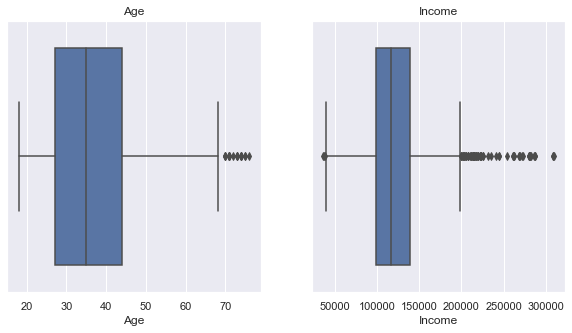

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(ax=axes[0], data=data, x='Age').set_title('Age')
sns.boxplot(ax=axes[1], data=data, x='Income').set_title('Income')

In [15]:
outliers=[]
columns = ['Age', 'Income']

def detect_outlier(data_1) -> int:
    """
    :data_1: dataset
    """
    
    counter = 0
    
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            counter += 1
    return counter

for col in columns:
    outliers.append(detect_outlier(data[col]))
    
cost = np.round(data[columns].max() / data[columns].quantile(0.95), 2)
    
pd.DataFrame(np.array([columns, outliers, 100*np.array(outliers)/len(data), cost]).T,
             columns=['column', 'num_of_outliers', 'percentage', 'exceed'])

,column,num_of_outliers,percentage,exceed
0,Age,7,0.40863981319322823,1.22
1,Income,26,1.5178050204319906,1.62


Some outliers in Age variable but nothing critical.

And outliers in Income variable where some of them are too large in compare with mean value. To not damage the model it should be preprocessed.

### Comparing feature magnitude

In [16]:
np.round((data[['Age', 'Income']].describe().loc[['max'], :].rename({'max':'magnitude'}).T
          - data[['Age', 'Income']].describe().loc[['min'], :].T.to_numpy()).merge(data[['Age', 'Income']].describe().loc[['mean'], :].T,
                                                                 left_index=True, right_index=True), 3)

,magnitude,mean
Age,58.0,37.333
Income,273532.0,121940.608


### Conclusion

- There are 5 categorical and 2 numerical features. 
- One variable with right-skewed distribution and one with normal distribution. 
- Presence of critical outliers in one variable.
- 287 rows with missed values were dropped.
- For categorical variables, only one variable has a rare class.
- Middle correlation between some variables.
- Income variable has 1.5% of outliers.

## Deep analysis

To provide deep analysis let's encode categorical variables with it's real values

In [17]:
data_encoded = data.copy()

data_encoded['Education'] = data_encoded['Education'].map({1:'High School',
                                                           2:'University',
                                                           3:'Graduate'})
data_encoded['Sex'] = data_encoded['Sex'].map({0: 'Male' ,
                                               1: 'Female'})

data_encoded['Marital status'] = data_encoded['Marital status'].map({0: 'Single' ,
                                                                     1: 'Non-Single'})

data_encoded['Occupation'] = data_encoded['Occupation'].map({0: 'Unemployed' ,
                                                             1: 'Official Employed',
                                                             2:'Self-Employed'})

data_encoded['Settlement size'] = data_encoded['Settlement size'].map({0: 'Small' ,
                                                                       1: 'Medium',
                                                                       2:'Large'})

data_encoded.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,Male,Single,67,University,124670,Official Employed,Large
1,Female,Non-Single,22,High School,150773,Official Employed,Large
2,Male,Single,49,High School,89210,Unemployed,Small
3,Male,Single,45,High School,171565,Official Employed,Medium
4,Male,Single,53,High School,149031,Official Employed,Medium


### To get representation about distribution of customers in different groups lets prepare summary statistic

         Age    Income
Sex                   
Male    41.0  130487.0
Female  34.0  113889.0


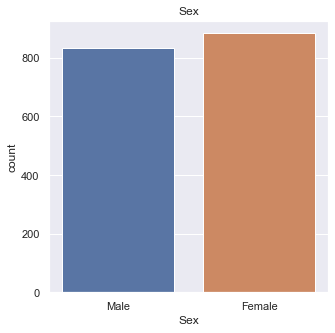

In [18]:
def statistic_summary(dataset, groupedby) -> None:
    """
    :datasets: data
    :groupedby: name of column to group data
    """
    
    plt.rcParams['figure.figsize'] = (5, 5)
    sns.countplot(data=dataset, x=groupedby)
    plt.title(groupedby)
    plt.plot()
    
    print(pd.pivot_table(index=[groupedby],
               aggfunc='mean', data=dataset[['Age', 'Income', groupedby]]).round(0).sort_values('Income', ascending=False))

statistic_summary(data_encoded, 'Sex')

The number of customers divided by gender is approximately equal. It is expected that both the age and income of men will be higher than that of women.

                  Age    Income
Settlement size                
Large            39.0  144749.0
Medium           39.0  137939.0
Small            35.0  102753.0


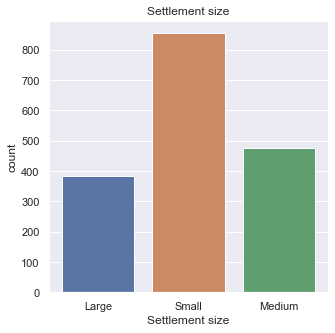

In [19]:
statistic_summary(data_encoded, 'Settlement size')

The number of buyers from small towns is approximately 50% of all supermarket customers. If we create targeted advertising, then we should take this factor into account. It is also expected that in a small city, customers have less purchasing power.

                    Age    Income
Occupation                       
Self-Employed      42.0  176424.0
Official Employed  36.0  125508.0
Unemployed         37.0   92849.0


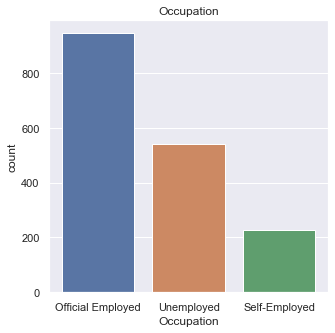

In [20]:
statistic_summary(data_encoded, 'Occupation')

Unexpectedly, the number of unemployed customers is very high. Our assumption is that these buyers are housewives. Let's take a closer look:

In [21]:
unemployed_data = data_encoded[data_encoded['Occupation'] == 'Unemployed']

<AxesSubplot:xlabel='Sex', ylabel='count'>

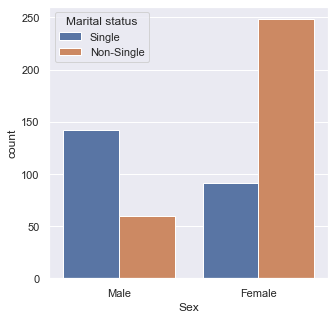

In [22]:
sns.countplot(data=unemployed_data, x='Sex', hue='Marital status')

The graph above partially confirms our assumption: the majority of our unemployed buyers are either married women or unmarried men.

                 Age    Income
Marital status                
Single          43.0  127191.0
Non-Single      33.0  118133.0


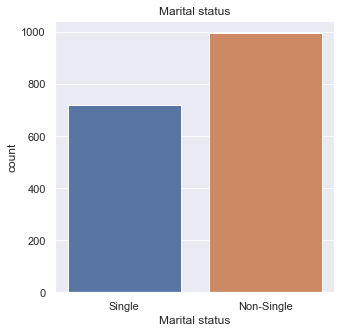

In [23]:
statistic_summary(data_encoded, 'Marital status')

It is also worth considering that we have 20% more non-single clients, which can be used in promotion.

              Age    Income
Education                  
Graduate     57.0  146818.0
University   54.0  145406.0
High School  33.0  116368.0


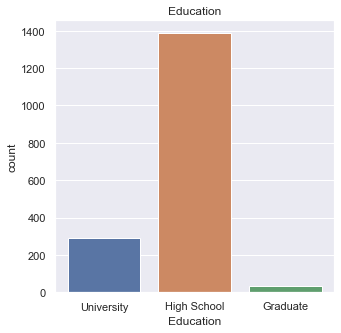

In [24]:
statistic_summary(data_encoded, 'Education')

The predominant majority of our clients are students with average solvency.

### To get some presentation about solvency in diffirent groups let's  group data by categorical variables:

In [25]:
pivot = pd.pivot_table(index=['Settlement size', 'Occupation','Sex', 'Marital status','Education' ],
               aggfunc=['mean', 'count'], data=data_encoded).round(0)
pivot.reindex(pivot['mean'].sort_values(by='Income', ascending=False).index)

mean  \
                                                                  Age   
Settlement size Occupation    Sex    Marital status Education           
Large           Self-Employed Male   Non-Single     University   46.0   
                                     Single         University   66.0   
Small           Self-Employed Male   Non-Single     University   60.0   
                              Female Non-Single     University   53.0   
Medium          Self-Employed Male   Single         University   65.0   
...                                                               ...   
Small           Unemployed    Female Single         High School  36.0   
                                     Non-Single     High School  28.0   
                              Male   Non-Single     High School  29.0   
Large           Unemployed    Male   Non-Single     Graduate     66.0   
Small           Unemployed    Female Single         Graduate     70.0   

                                                                           \
                                                                   Income   
Settlement size Occupation    Sex    Marital status Education               
Large           Self-Employed Male   Non-Single     University   238201.0   
                                     Single         University   226775.0   
Small           Self-Employed Male   Non-Single     University   212020.0   
                              Female Non-Single     University   211229.0   
Medium          Self-Employed Male   Single         University   208466.0   
...                                                                   ...   
Small           Unemployed    Female Single         High School   87050.0   
                                     Non-Single     High School   85977.0   
                              Male   Non-Single     High School   79011.0   
Large           Unemployed    Male   Non-Single     Graduate      70655.0   
Small           Unemployed    Female Single         Graduate      69915.0   

                                                                count         
                                                                  Age Income  
Settlement size Occupation    Sex    Marital status Education                 
Large           Self-Employed Male   Non-Single     University      6      6  
                                     Single         University     11     11  
Small           Self-Employed Male   Non-Single     University      1      1  
                              Female Non-Single     University      1      1  
Medium          Self-Employed Male   Single         University     12     12  
...                                                               ...    ...  
Small           Unemployed    Female Single         High School    75     75  
                                     Non-Single     High School   186    186  
                              Male   Non-Single     High School    42     42  
Large           Unemployed    Male   Non-Single     Graduate        2      2  
Small           Unemployed    Female Single         Graduate        1      1  

[70 rows x 4 columns]

From here we consider two main keys:
- The most solvent audience is self-employed men. Their amount is extremely small.
- The most unsolvent audience is unemployed customers. From theme we can extract unemployed non-single women (housewifes).

### To get some presentation about amount of clients in diffirent groups let's  group data by categorical variables:

In [26]:
pivot = pd.pivot_table(index=['Settlement size', 'Occupation','Sex', 'Marital status','Education' ],
               aggfunc=['mean', 'count'], data=data_encoded).round(0)
pivot.reindex(pivot['count'].sort_values(by='Income', ascending=False).index)

mean  \
                                                                      Age   
Settlement size Occupation        Sex    Marital status Education           
Small           Unemployed        Female Non-Single     High School  28.0   
                Official Employed Female Non-Single     High School  28.0   
Medium          Official Employed Female Non-Single     High School  28.0   
                                  Male   Single         High School  43.0   
Small           Unemployed        Male   Single         High School  41.0   
...                                                                   ...   
                Self-Employed     Female Non-Single     Graduate     67.0   
Medium          Official Employed Female Single         University   57.0   
Small           Official Employed Female Single         Graduate     66.0   
Medium          Unemployed        Female Non-Single     High School  35.0   
Small           Self-Employed     Female Non-Single     University   53.0   

                                                                               \
                                                                       Income   
Settlement size Occupation        Sex    Marital status Education               
Small           Unemployed        Female Non-Single     High School   85977.0   
                Official Employed Female Non-Single     High School  115162.0   
Medium          Official Employed Female Non-Single     High School  117449.0   
                                  Male   Single         High School  134295.0   
Small           Unemployed        Male   Single         High School   93015.0   
...                                                                       ...   
                Self-Employed     Female Non-Single     Graduate     171052.0   
Medium          Official Employed Female Single         University   113334.0   
Small           Official Employed Female Single         Graduate     131001.0   
Medium          Unemployed        Female Non-Single     High School  167945.0   
Small           Self-Employed     Female Non-Single     University   211229.0   

                                                                    count  \
                                                                      Age   
Settlement size Occupation        Sex    Marital status Education           
Small           Unemployed        Female Non-Single     High School   186   
                Official Employed Female Non-Single     High School   163   
Medium          Official Employed Female Non-Single     High School   133   
                                  Male   Single         High School   109   
Small           Unemployed        Male   Single         High School   103   
...                                                                   ...   
                Self-Employed     Female Non-Single     Graduate        1   
Medium          Official Employed Female Single         University      1   
Small           Official Employed Female Single         Graduate        1   
Medium          Unemployed        Female Non-Single     High School     1   
Small           Self-Employed     Female Non-Single     University      1   

                                                                            
                                                                    Income  
Settlement size Occupation        Sex    Marital status Education           
Small           Unemployed        Female Non-Single     High School    186  
                Official Employed Female Non-Single     High School    163  
Medium          Official Employed Female Non-Single     High School    133  
                                  Male   Single         High School    109  
Small           Unemployed        Male   Single         High School    103  
...                                                                    ...  
                Self-Employed     Female Non-Single     Graduate         1  
Medium

Our the most distibuted clients are:
- Unemployed and official employed non-single women from small and medium cities with average solvency.
- Unemployed single men from small cities with medium and small solvency.

### Conclusion:
- Since our buyers have a medium-low purchasing power, our goods must be cheap.
- It is worth targeting ads and holding promotions for non-single clients.
- Most of our clients live in small towns, it may be worth using radio, local TV and outdoor advertising.

## Apply some data preparation

In [27]:
data_preprocessed = data.copy()

### Handling outliers

To handle outliers we can use winsorising. It limits outlier values into 5-95% percentage

In [28]:
outliers=[]
columns = ['Age', 'Income']

for col in columns:
    outliers.append(detect_outlier(data[col]))
    
cost = np.round(data[columns].max() / data[columns].quantile(0.95), 2)
    
pd.DataFrame(np.array([columns, outliers, 100*np.array(outliers)/len(data), cost]).T,
             columns=['column', 'num_of_outliers', 'percentage', 'exceed'])

,column,num_of_outliers,percentage,exceed
0,Age,7,0.40863981319322823,1.22
1,Income,26,1.5178050204319906,1.62


**Age**

count    1713.000000
mean       37.333333
std        12.019762
min        18.000000
25%        27.000000
50%        35.000000
75%        44.000000
max        76.000000
Name: Age, dtype: float64


<AxesSubplot:ylabel='Density'>

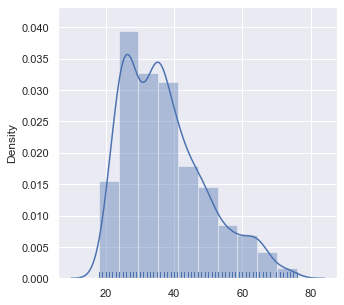

In [29]:
print(data_preprocessed['Age'].describe().T)
sns.distplot(x=data_preprocessed['Age'], rug=True, bins=10)

In [30]:
data_preprocessed['Age'] = winsorize(data_preprocessed['Age'], limits=(0, 0.05))

count    1713.000000
mean       37.145943
std        11.553803
min        18.000000
25%        27.000000
50%        35.000000
75%        44.000000
max        63.000000
Name: Age, dtype: float64


<AxesSubplot:ylabel='Density'>

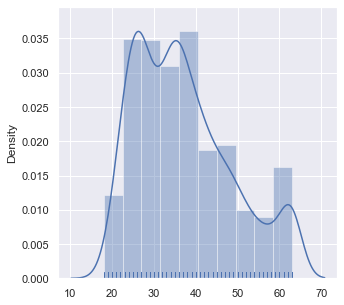

In [31]:
print(data_preprocessed['Age'].describe().T)
sns.distplot(x=data_preprocessed['Age'], rug=True, bins=10)

How you can see there is no any radical changes.

**Income**

count      1713.000000
mean     121940.607706
std       37694.643813
min       35832.000000
25%       98742.000000
50%      116103.000000
75%      138644.000000
max      309364.000000
Name: Income, dtype: float64


<AxesSubplot:ylabel='Density'>

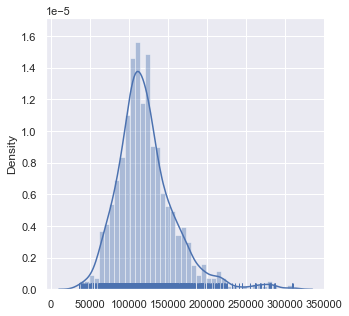

In [32]:
print(data_preprocessed['Income'].describe().T)
sns.distplot(x=data_preprocessed['Income'], rug=True)

In [33]:
data_preprocessed['Income'] = winsorize(data_preprocessed['Income'], limits=(0, 0.05))

count      1713.000000
mean     120131.312318
std       32366.790724
min       35832.000000
25%       98742.000000
50%      116103.000000
75%      138644.000000
max      190518.000000
Name: Income, dtype: float64


<AxesSubplot:ylabel='Density'>

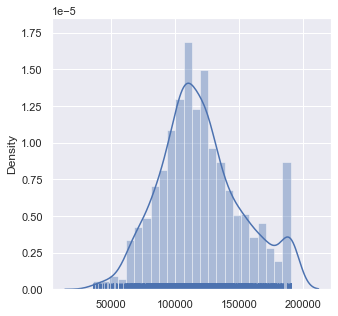

In [34]:
print(data_preprocessed['Income'].describe().T)
sns.distplot(x=data_preprocessed['Income'], rug=True)

In [35]:
print(data_preprocessed.shape)

(1713, 7)


### Encoding categorical variables

In [36]:
for column in ['Education','Occupation','Settlement size']:
    
    data_preprocessed = data_preprocessed.merge(pd.get_dummies(data_preprocessed[column]),
                                      left_index=True, right_index=True)
    del data_preprocessed[column]

data_preprocessed.head()

,Sex,Marital status,Age,Income,1.0_x,2.0_x,3.0,0_x,1_y,2_y,0_y,1,2
0,0,0,63,124670,0,1,0,0,1,0,0,0,1
1,1,1,22,150773,1,0,0,0,1,0,0,0,1
2,0,0,49,89210,1,0,0,1,0,0,1,0,0
3,0,0,45,171565,1,0,0,0,1,0,0,1,0
4,0,0,53,149031,1,0,0,0,1,0,0,1,0


### Data scaling

In [37]:
data_preprocessed.loc[:, ['Age', 'Income']] = scale(data_preprocessed.loc[:, ['Age', 'Income']])

In [38]:
data_preprocessed

,Sex,Marital status,Age,Income,1.0_x,2.0_x,3.0,0_x,1_y,2_y,0_y,1,2
0,0,0,2.238363,0.140268,0,1,0,0,1,0,0,0,1
1,1,1,-1.311288,0.946978,1,0,0,0,1,0,0,0,1
2,0,0,1.026287,-0.955620,1,0,0,1,0,0,1,0,0
3,0,0,0.679980,1.589552,1,0,0,0,1,0,0,1,0
4,0,0,1.372594,0.893142,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,1,0,0.073942,-1.003213,1,0,0,1,0,0,1,0,0
1994,0,0,0.679980,-0.207598,1,0,0,0,1,0,1,0,0
1995,1,0,0.853133,0.104882,1,0,0,1,0,0,1,0,0
1996,1,1,-0.878404,-0.073780,1,0,0,0,1,0,1,0,0


## Apply clustering model

### The first step is to determine the number of clusters:

Using WSS:

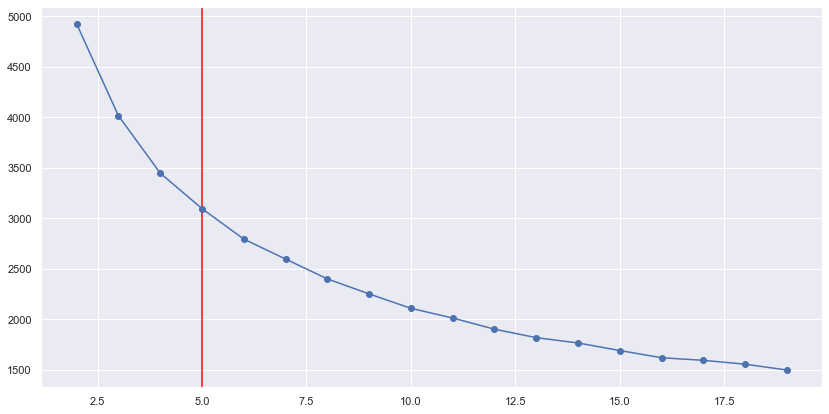

In [39]:
list_of_wss = []
for i in range(2, 20):
    model = KMeans(i, random_state=42)
    model.fit(data_preprocessed)
    list_of_wss.append(model.inertia_)

plt.rcParams['figure.figsize'] = (14, 7)
plt.axvline(5, color='red')
plt.plot(range(2, 20), list_of_wss, marker='o')

Using silhouette score: **!!!(code copied from sklearn [link](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#:~:text=The%20silhouette%20plot%20displays%20a,of%20%5B%2D1%2C%201%5D.))!!!**

In [40]:
def best_n_clusters(X, range_n_clusters, visualize):
    for n_clusters in range_n_clusters:
        if visualize:
            # Create a subplot with 1 row and 2 columns
            fig, (ax1, ax2) = plt.subplots(1, 2)
            fig.set_size_inches(18, 7)

            # The 1st subplot is the silhouette plot
            # The silhouette coefficient can range from -1, 1 but in this example all
            # lie within [-0.1, 1]
            ax1.set_xlim([-0.1, 1])
            # The (n_clusters+1)*10 is for inserting blank space between silhouette
            # plots of individual clusters, to demarcate them clearly.
            ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )
        
        if visualize:
            # Compute the silhouette scores for each sample
            sample_silhouette_values = silhouette_samples(X, cluster_labels)

            y_lower = 10
            for i in range(n_clusters):
                # Aggregate the silhouette scores for samples belonging to
                # cluster i, and sort them
                ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

                ith_cluster_silhouette_values.sort()

                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i

                color = cm.nipy_spectral(float(i) / n_clusters)
                ax1.fill_betweenx(
                    np.arange(y_lower, y_upper),
                    0,
                    ith_cluster_silhouette_values,
                    facecolor=color,
                    edgecolor=color,
                    alpha=0.7,
                )

                # Label the silhouette plots with their cluster numbers at the middle
                ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                # Compute the new y_lower for next plot
                y_lower = y_upper + 10  # 10 for the 0 samples

            ax1.set_title("The silhouette plot for the various clusters.")
            ax1.set_xlabel("The silhouette coefficient values")
            ax1.set_ylabel("Cluster label")

            # The vertical line for average silhouette score of all the values
            ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

            ax1.set_yticks([])  # Clear the yaxis labels / ticks
            ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

            # 2nd Plot showing the actual clusters formed
            colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
            ax2.scatter(
                X[:, 2], X[:,3], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
            )

            # Labeling the clusters
            centers = clusterer.cluster_centers_
            # Draw white circles at cluster centers
            ax2.scatter(
                centers[:, 2],
                centers[:, 3],
                marker="o",
                c="white",
                alpha=1,
                s=200,
                edgecolor="k",
            )

            for i, c in enumerate(centers):
                ax2.scatter(c[2], c[3], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

            ax2.set_title("The visualization of the clustered data.")
            ax2.set_xlabel("Feature space for the 1st feature")
            ax2.set_ylabel("Feature space for the 2nd feature")

            plt.suptitle(
                "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
                % n_clusters,
                fontsize=14,
                fontweight="bold",
            )

        plt.show()
    
best_n_clusters(data_preprocessed, list(range(2, 20)), False)

For n_clusters = 2 The average silhouette_score is : 0.27216850290336136
For n_clusters = 3 The average silhouette_score is : 0.2463161709396325
For n_clusters = 4 The average silhouette_score is : 0.2510089024046795
For n_clusters = 5 The average silhouette_score is : 0.2546110319443604
For n_clusters = 6 The average silhouette_score is : 0.26335653368317674
For n_clusters = 7 The average silhouette_score is : 0.26133856685258944
For n_clusters = 8 The average silhouette_score is : 0.2660351227336181
For n_clusters = 9 The average silhouette_score is : 0.2709665284965399
For n_clusters = 10 The average silhouette_score is : 0.2711896064294486
For n_clusters = 11 The average silhouette_score is : 0.29717051609874423
For n_clusters = 12 The average silhouette_score is : 0.305261634373782
For n_clusters = 13 The average silhouette_score is : 0.31147167211900073
For n_clusters = 14 The average silhouette_score is : 0.2992141872467688
For n_clusters = 15 The average silhouette_score is : 0

For n_clusters = 5 The average silhouette_score is : 0.2546110319443604


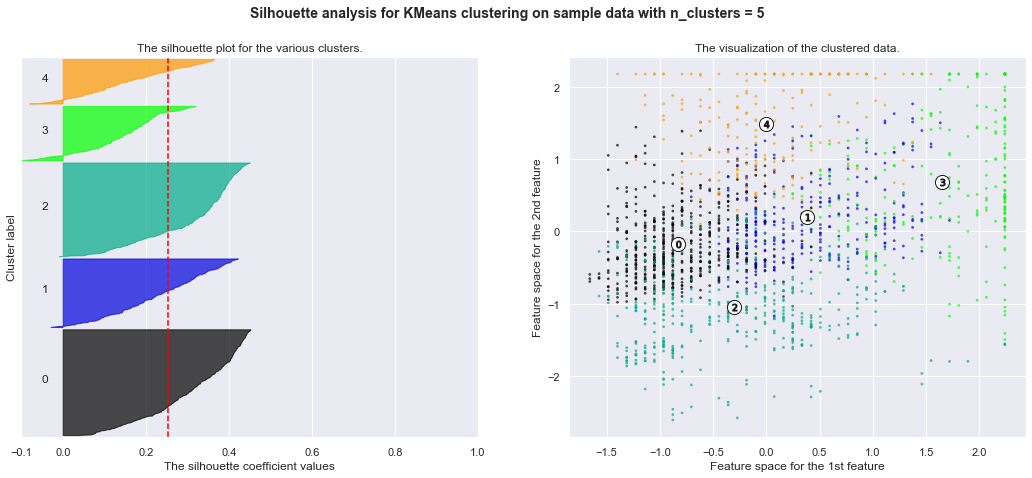

In [41]:
best_n_clusters(data_preprocessed.to_numpy(), [5], True)

#### Conclusion:

The optimal number of clusters is 5.

### Build the model and get result

In [42]:
labels = KMeans(n_clusters=5, init='k-means++', n_init=15,
                max_iter=300, random_state=42).fit_predict(data_preprocessed)

### Model evaluation

In [43]:
silhouette_kmeans = silhouette_score(data_preprocessed, labels, metric='euclidean')
calinski_harabasz_kmeans = calinski_harabasz_score(data_preprocessed, labels)
davies_bouldin_kmeans = davies_bouldin_score(data_preprocessed, labels)

print(f'Silhouette Coefficient: {silhouette_kmeans}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_kmeans}')
print(f'Davies-Bouldin Index: {davies_bouldin_kmeans}')

Silhouette Coefficient: 0.25467034175917813
Calinski-Harabasz Index: 521.5172337681454
Davies-Bouldin Index: 1.3986470342467476


### Conclusion:
- Clusters are poorly separated (Silhouette Coefficient & Davies-Bouldin Index)
- Badly defined clusters (Calinski-Harabasz Index)

### Using agglomerative clustering to compare results

In [44]:
labels_aggclust = AgglomerativeClustering(n_clusters=5).fit_predict(data_preprocessed)

In [45]:
silhouette_kmeans = silhouette_score(data_preprocessed, labels_aggclust, metric='euclidean')
calinski_harabasz_kmeans = calinski_harabasz_score(data_preprocessed, labels_aggclust)
davies_bouldin_kmeans = davies_bouldin_score(data_preprocessed, labels_aggclust)

print(f'Silhouette Coefficient: {silhouette_kmeans}')
print(f'Calinski-Harabasz Index: {calinski_harabasz_kmeans}')
print(f'Davies-Bouldin Index: {davies_bouldin_kmeans}')

Silhouette Coefficient: 0.2230845988770353
Calinski-Harabasz Index: 474.36368105036973
Davies-Bouldin Index: 1.4497103898833188


### Conclusion:
- Here we can see the same results for agglomerative clustering

However, in order to verify the results, it is necessary to conduct a final analysis of the clusters and try to find dependencies between the combined clients. This will be the main metric.

## Visualise your obtained clusters

### Using PCA

For KMeans:

<AxesSubplot:>

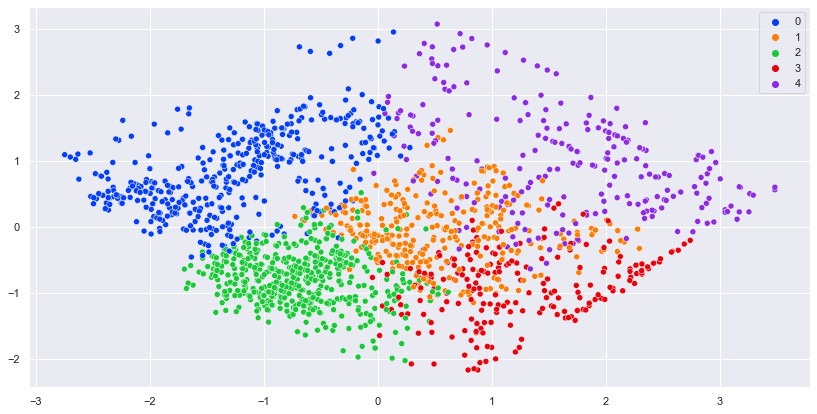

In [46]:
pca = PCA(n_components=2).fit_transform(data_preprocessed)

sns.scatterplot(x=pca[:, 0], y=pca[:, 1], hue=labels, palette=sns.color_palette("bright")[:5])

In [47]:
pca = PCA(n_components=3).fit_transform(data_preprocessed)

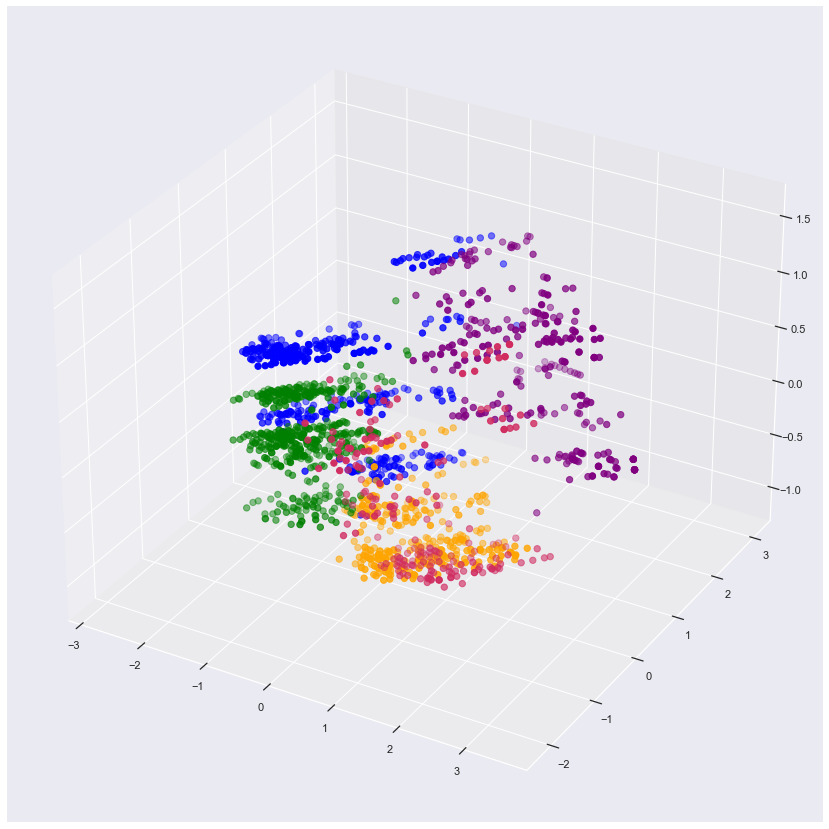

In [48]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca[labels == 0][:, 0], pca[labels == 0][:, 1], pca[labels == 0][:, 2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(pca[labels == 1][:, 0], pca[labels == 1][:, 1], pca[labels == 1][:, 2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(pca[labels == 2][:, 0], pca[labels == 2][:, 1], pca[labels == 2][:, 2], s = 40 , color = 'green', label = "cluster 2")
ax.scatter(pca[labels == 3][:, 0], pca[labels == 3][:, 1], pca[labels == 3][:, 2], s = 40 , color = '#D12B60', label = "cluster 3")
ax.scatter(pca[labels == 4][:, 0], pca[labels == 4][:, 1], pca[labels == 4][:, 2], s = 40 , color = 'purple', label = "cluster 4")
plt.show()

For agglomerative clustering:

<AxesSubplot:>

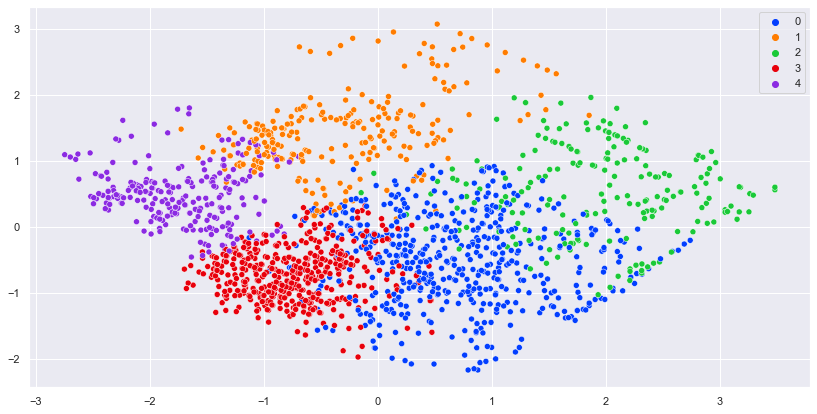

In [49]:
pca = PCA(n_components=2).fit_transform(data_preprocessed)

sns.scatterplot(x=pca[:, 0], y=pca[:, 1], hue=labels_aggclust, palette=sns.color_palette("bright")[:5])

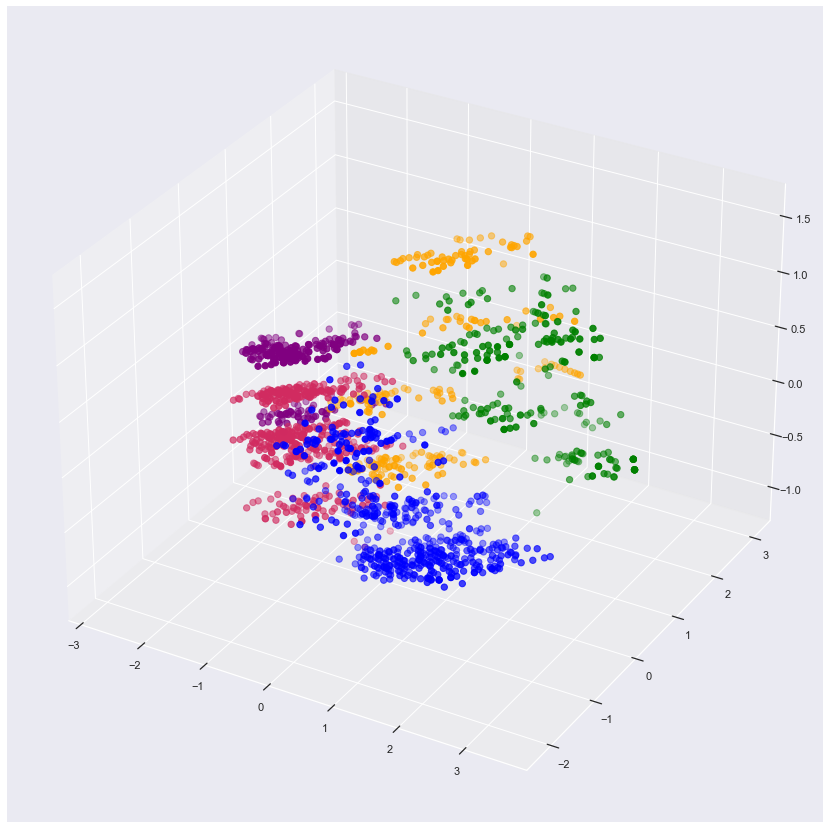

In [50]:
pca = PCA(n_components=3).fit_transform(data_preprocessed)

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca[labels_aggclust == 0][:, 0], pca[labels_aggclust == 0][:, 1], pca[labels_aggclust == 0][:, 2], s = 40 , color = 'blue', label = "cluster 0")
ax.scatter(pca[labels_aggclust == 1][:, 0], pca[labels_aggclust == 1][:, 1], pca[labels_aggclust == 1][:, 2], s = 40 , color = 'orange', label = "cluster 1")
ax.scatter(pca[labels_aggclust == 2][:, 0], pca[labels_aggclust == 2][:, 1], pca[labels_aggclust == 2][:, 2], s = 40 , color = 'green', label = "cluster 2")
ax.scatter(pca[labels_aggclust == 3][:, 0], pca[labels_aggclust == 3][:, 1], pca[labels_aggclust == 3][:, 2], s = 40 , color = '#D12B60', label = "cluster 3")
ax.scatter(pca[labels_aggclust == 4][:, 0], pca[labels_aggclust == 4][:, 1], pca[labels_aggclust == 4][:, 2], s = 40 , color = 'purple', label = "cluster 4")
plt.show()

We guess clustorization result are similar for both KMeans and Agglomerative clustering

## Conclusion:

To draw final conclusions, let's analyze the obtained classters:

### Cluster 1:

In [51]:
pivot = pd.pivot_table(index=['Settlement size', 'Occupation','Sex', 'Marital status','Education'],
               aggfunc=['mean', 'count'], data=data_encoded[labels == 0]).round(0)
pivot.reindex(pivot['count'].sort_values(by='Income', ascending=False).index)[:5]

mean           \
                                                               Age   Income   
Settlement size Occupation Sex    Marital status Education                    
Small           Unemployed Female Non-Single     High School  28.0  85463.0   
                           Male   Single         High School  40.0  89303.0   
                           Female Single         High School  36.0  87050.0   
                           Male   Non-Single     High School  29.0  76661.0   
                           Female Non-Single     University   46.0  88198.0   

                                                             count         
                                                               Age Income  
Settlement size Occupation Sex    Marital status Education                 
Small           Unemployed Female Non-Single     High School   185    185  
                           Male   Single         High School    94     94  
                           Female Single         High School    75     75  
                           Male   Non-Single     High School    41     41  
                           Female Non-Single     University     25     25

The first cluster characterizes the category of unemployed women and men with low solvency. This category of people can be attracted by cheap essentials and regular discounts.

### Cluster 2:

In [52]:
pivot = pd.pivot_table(index=['Settlement size', 'Occupation','Sex', 'Marital status','Education'],
               aggfunc=['mean', 'count'], data=data_encoded[labels == 1]).round(0)
pivot.reindex(pivot['count'].sort_values(by='Income', ascending=False).index)[:5]

mean  \
                                                                      Age   
Settlement size Occupation        Sex    Marital status Education           
Medium          Official Employed Male   Single         High School  43.0   
Large           Official Employed Male   Single         High School  42.0   
Small           Official Employed Male   Single         High School  41.0   
                                  Female Single         High School  42.0   
Medium          Unemployed        Male   Single         High School  40.0   

                                                                               \
                                                                       Income   
Settlement size Occupation        Sex    Marital status Education               
Medium          Official Employed Male   Single         High School  129482.0   
Large           Official Employed Male   Single         High School  130769.0   
Small           Official Employed Male   Single         High School  121494.0   
                                  Female Single         High School  118871.0   
Medium          Unemployed        Male   Single         High School  121050.0   

                                                                    count  \
                                                                      Age   
Settlement size Occupation        Sex    Marital status Education           
Medium          Official Employed Male   Single         High School   101   
Large           Official Employed Male   Single         High School    90   
Small           Official Employed Male   Single         High School    63   
                                  Female Single         High School    17   
Medium          Unemployed        Male   Single         High School    12   

                                                                            
                                                                    Income  
Settlement size Occupation        Sex    Marital status Education           
Medium          Official Employed Male   Single         High School    101  
Large           Official Employed Male   Single         High School     90  
Small           Official Employed Male   Single         High School     63  
                                  Female Single         High School     17  
Medium          Unemployed        Male   Single         High School     12

The next cluster characterizes single working men. This category of people can be attracted, for example, by ready meals.

### Cluster 3:

In [53]:
pivot = pd.pivot_table(index=['Settlement size', 'Occupation','Sex', 'Marital status','Education'],
               aggfunc=['mean', 'count'], data=data_encoded[labels == 2]).round(0)
pivot.reindex(pivot['count'].sort_values(by='Income', ascending=False).index)[:5]

mean  \
                                                                      Age   
Settlement size Occupation        Sex    Marital status Education           
Small           Official Employed Female Non-Single     High School  28.0   
Medium          Official Employed Female Non-Single     High School  27.0   
Large           Official Employed Female Non-Single     High School  26.0   
Small           Official Employed Male   Non-Single     High School  28.0   
Large           Official Employed Male   Non-Single     High School  27.0   

                                                                               \
                                                                       Income   
Settlement size Occupation        Sex    Marital status Education               
Small           Official Employed Female Non-Single     High School  114096.0   
Medium          Official Employed Female Non-Single     High School  115694.0   
Large           Official Employed Female Non-Single     High School  115822.0   
Small           Official Employed Male   Non-Single     High School  111134.0   
Large           Official Employed Male   Non-Single     High School  114393.0   

                                                                    count  \
                                                                      Age   
Settlement size Occupation        Sex    Marital status Education           
Small           Official Employed Female Non-Single     High School   161   
Medium          Official Employed Female Non-Single     High School   129   
Large           Official Employed Female Non-Single     High School    58   
Small           Official Employed Male   Non-Single     High School    35   
Large           Official Employed Male   Non-Single     High School    35   

                                                                            
                                                                    Income  
Settlement size Occupation        Sex    Marital status Education           
Small           Official Employed Female Non-Single     High School    161  
Medium          Official Employed Female Non-Single     High School    129  
Large           Official Employed Female Non-Single     High School     58  
Small           Official Employed Male   Non-Single     High School     35  
Large           Official Employed Male   Non-Single     High School     35

The third cluster characterizes working non-single men and women. The category of married couples can be attracted, for example, by toys for children.

### Cluster 4:

In [54]:
pivot = pd.pivot_table(index=['Settlement size', 'Occupation','Sex', 'Marital status','Education'],
               aggfunc=['mean', 'count'], data=data_encoded[labels == 3]).round(0)
pivot.reindex(pivot['count'].sort_values(by='Income', ascending=False).index)[:5]

mean  \
                                                                  Age   
Settlement size Occupation    Sex    Marital status Education           
Large           Self-Employed Male   Single         High School  40.0   
Medium          Self-Employed Male   Single         High School  39.0   
                                     Non-Single     High School  33.0   
                              Female Non-Single     High School  29.0   
Large           Self-Employed Female Non-Single     High School  30.0   

                                                                           \
                                                                   Income   
Settlement size Occupation    Sex    Marital status Education               
Large           Self-Employed Male   Single         High School  169553.0   
Medium          Self-Employed Male   Single         High School  169215.0   
                                     Non-Single     High School  168851.0   
                              Female Non-Single     High School  180092.0   
Large           Self-Employed Female Non-Single     High School  182997.0   

                                                                count         
                                                                  Age Income  
Settlement size Occupation    Sex    Marital status Education                 
Large           Self-Employed Male   Single         High School    60     60  
Medium          Self-Employed Male   Single         High School    29     29  
                                     Non-Single     High School    12     12  
                              Female Non-Single     High School    11     11  
Large           Self-Employed Female Non-Single     High School     9      9

The fourth cluster describes self-employed clients. To attract self-employed people with high income, you can use luxury segment products.

### Cluster 5:

In [55]:
pivot = pd.pivot_table(index=['Settlement size', 'Occupation','Sex', 'Marital status','Education'],
               aggfunc=['mean', 'count'], data=data_encoded[labels == 4]).round(0)
pivot.reindex(pivot['count'].sort_values(by='Income', ascending=False).index)[:5]

mean  \
                                                                     Age   
Settlement size Occupation        Sex    Marital status Education          
Medium          Official Employed Female Non-Single     University  53.0   
Small           Unemployed        Female Non-Single     University  52.0   
Medium          Official Employed Male   Non-Single     University  54.0   
                                         Single         University  62.0   
Large           Official Employed Male   Single         University  64.0   

                                                                              \
                                                                      Income   
Settlement size Occupation        Sex    Marital status Education              
Medium          Official Employed Female Non-Single     University  146971.0   
Small           Unemployed        Female Non-Single     University  111159.0   
Medium          Official Employed Male   Non-Single     University  147570.0   
                                         Single         University  159314.0   
Large           Official Employed Male   Single         University  139183.0   

                                                                   count  \
                                                                     Age   
Settlement size Occupation        Sex    Marital status Education          
Medium          Official Employed Female Non-Single     University    27   
Small           Unemployed        Female Non-Single     University    26   
Medium          Official Employed Male   Non-Single     University    18   
                                         Single         University    17   
Large           Official Employed Male   Single         University    16   

                                                                           
                                                                   Income  
Settlement size Occupation        Sex    Marital status Education          
Medium          Official Employed Female Non-Single     University     27  
Small           Unemployed        Female Non-Single     University     26  
Medium          Official Employed Male   Non-Single     University     18  
                                         Single         University     17  
Large           Official Employed Male   Single         University     16

And the last cluster describes the rest of the men and women who do not fit the first four categories.